라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
model_name = 'doRegressor_tank1nomal'

In [29]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='actual')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
    plt.xlabel('Day')
    plt.ylabel('DO')
    plt.title('day time')
    plt.legend(['y_test','X_pred'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)



데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset\japonica_training_food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_sensor_val_tb.csv")

#자포니카 훈련 데이터 시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

#자포니카 검증 데이터 시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

#자포니카 훈련 및 검증 데이터 시계열 변환
japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

In [4]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_training_tank = japonica_training[japonica_training['tank_id']==tank]
japonica_validation_tank = japonica_validation[japonica_validation['tank_id']==tank]

In [5]:
# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training_tank[feature_origin]
japonica_validation_features = japonica_validation_tank[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

In [6]:
# 시계열 데이터의 개수 확인
training_counts = japonica_training_features.groupby(japonica_training_features['mea_dt'].dt.date).size()
#validation_counts = japonica_validation_features.groupby(japonica_validation_features.index.mea_dt).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_data = japonica_training_features[~japonica_training_features['mea_dt'].dt.date.isin(to_delete)]

#to_delete = validation_counts[validation_counts != 1440].index
#japonica_validation_data = japonica_validation_features[~japonica_validation_features.index.floor('D').isin(to_delete)]

In [7]:
japonica_validation_data = japonica_validation_features

In [8]:
# 날짜 데이터를 인덱스로 전환
japonica_training_data.set_index('mea_dt', inplace=True)
japonica_validation_data.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_data.sort_index()
japonica_validation_data = japonica_validation_data.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [9]:
japonica_training_features_X = japonica_training_data[['do_mg','feed_quantity']]

japonica_validation_features_X = japonica_validation_data[['do_mg', 'feed_quantity']]

In [36]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max 스케일러 객체를 생성합니다.
scaler = MinMaxScaler()

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(japonica_training_features_X)
japonica_training_features_X = pd.DataFrame(normalized_data, columns=japonica_training_features_X.columns)

normalized_data = scaler.fit_transform(japonica_validation_features_X)
japonica_validation_features_X = pd.DataFrame(normalized_data, columns=japonica_validation_features_X.columns)

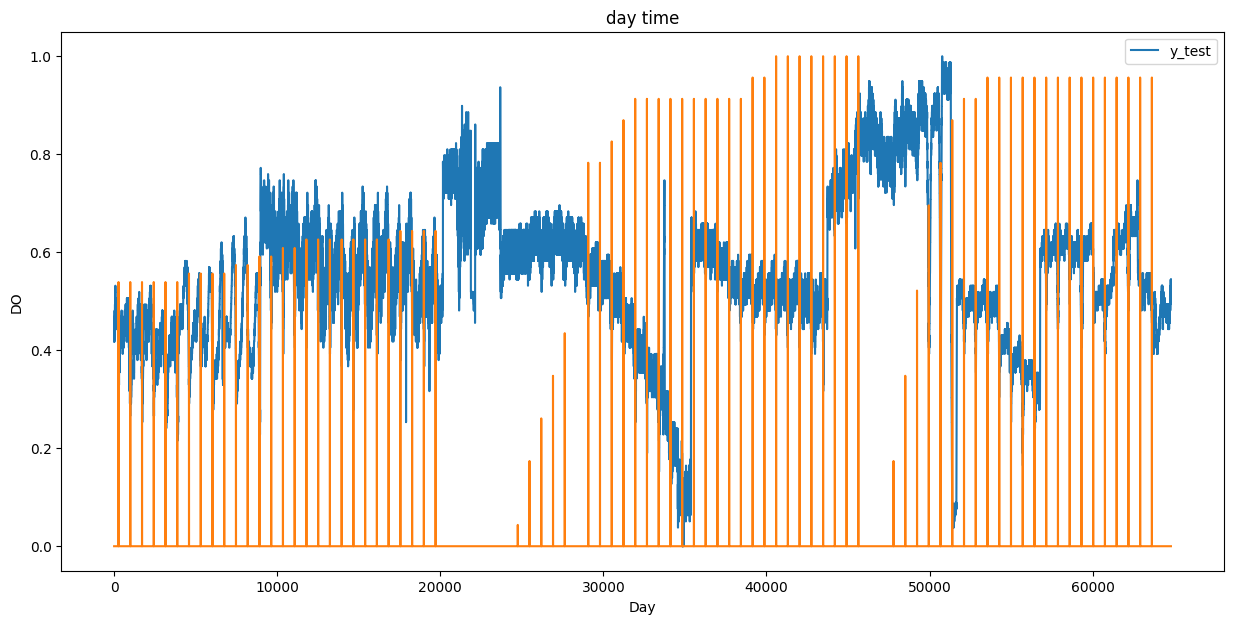

In [39]:
plt.figure(figsize=(15, 7))
plt.plot(japonica_training_features_X.index, japonica_training_features_X, label='actual')  # x축에 년월일, y축에 값
plt.xlabel('Day')
plt.ylabel('DO')
plt.title('day time')
plt.legend(['y_test'])
plt.show()

In [11]:
japonica_training_features_y = japonica_training_features_X[['do_mg']]

japonica_validation_features_y = japonica_validation_features_X[['do_mg']]

In [12]:
japonica_training_features_X_chunks = []
japonica_training_features_y_chunks = []

for i in range(0, len(japonica_training_features_X) - 179):
    japonica_training_features_X_chunks.append(np.array(japonica_training_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_X_chunks = np.array(japonica_training_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_training_features_y) - 179):
    japonica_training_features_y_chunks.append(np.array(japonica_training_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_y_chunks = np.array(japonica_training_features_y_chunks, dtype=np.float64)


In [13]:
japonica_validation_features_X_chunks = []
japonica_validation_features_y_chunks = []


for i in range(0, len(japonica_validation_features_X) - 179):
    japonica_validation_features_X_chunks.append(np.array(japonica_validation_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_X_chunks = np.array(japonica_validation_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_validation_features_y) - 179):
    japonica_validation_features_y_chunks.append(np.array(japonica_validation_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_y_chunks = np.array(japonica_validation_features_y_chunks, dtype=np.float64)

In [14]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64621 nVar: 2
nCar: 64621 nVar: 180
nCar: 74120 nVar: 2
nCar: 74120 nVar: 180


In [15]:
japonica_training_features_X_chunks_crop = japonica_training_features_X_chunks[:-180]
japonica_training_features_y_chunks_crop = japonica_training_features_y_chunks[180:]

japonica_validation_features_X_chunks_crop = japonica_validation_features_X_chunks[:-180]
japonica_validation_features_y_chunks_crop = japonica_validation_features_y_chunks[180:]

In [16]:
nCar = japonica_training_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64441 nVar: 2
nCar: 64441 nVar: 180
nCar: 73940 nVar: 2
nCar: 73940 nVar: 180


In [31]:
min_value = scaler.data_min_[0]
max_value = scaler.data_max_[0]

LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

모델 평가

In [214]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = 'doRegressor_tank1nomal'

In [215]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='actual')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
    plt.xlabel('Day')
    plt.ylabel('DO')
    plt.title('day time')
    plt.legend(['y_test','X_pred'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

def grapeNEva2(model, X_test_shape, y_test, y_test_shape, min_value, max_value):
    X_pred = model.predict(X_test_shape)
    X_pred = (X_pred * (max_value - min_value)) + min_value
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='actual')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
    plt.xlabel('Day')
    plt.ylabel('DO')
    plt.title('day time')
    plt.legend(['y_test','X_pred'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [216]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[-0.20703664  0.3606739  -0.06086511 ...  0.04028733  0.14169344
   0.25056908]
 [-0.39540797  0.12572996 -0.01560161 ... -0.15051678  0.02810638
   0.08622668]]


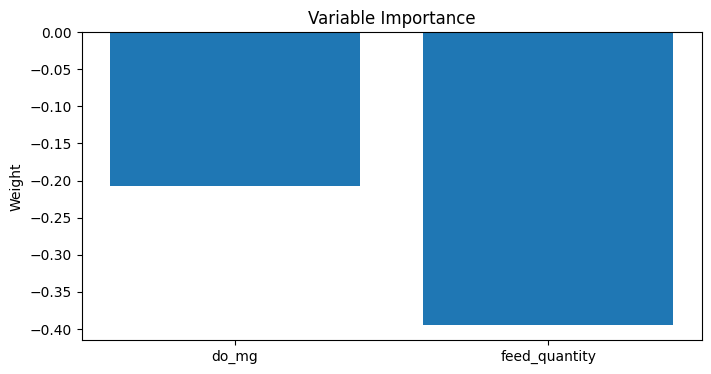

In [217]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(2), weights[:, 0])
ax.set_xticks(range(2))
ax.set_xticklabels(['do_mg', 'feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [218]:
#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_sensor_val_tb.csv")

#자포니카 검증 데이터 시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_tank = japonica_validation[japonica_validation['tank_id']==tank]

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_validation_features = japonica_validation_tank[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_validation_features = japonica_validation_features.fillna(0)

# 시계열 데이터의 개수 확인
validation_counts = japonica_validation_features.groupby(japonica_validation_features['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_data = japonica_validation_features[~japonica_validation_features['mea_dt'].dt.date.isin(to_delete)]

# 날짜 데이터를 인덱스로 전환
japonica_validation_data.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_validation_data = japonica_validation_data.sort_index()

In [219]:
# 한달 동안의 데이터 추출
one_day_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-08 20:59']
oneday_X_test = one_day_data[['do_mg', 'feed_quantity']]
one_day_data = japonica_validation_data.loc['2021-07-21 03:00':'2021-09-08 23:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 2))
oneday_y_test_reshape = np.asarray(oneday_y_test, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 359 nVar: 2
nCar: 64620 nVar: 1
nCar: 359 nVar: 180


12/12 [==============================] - 2s 65ms/step
64620


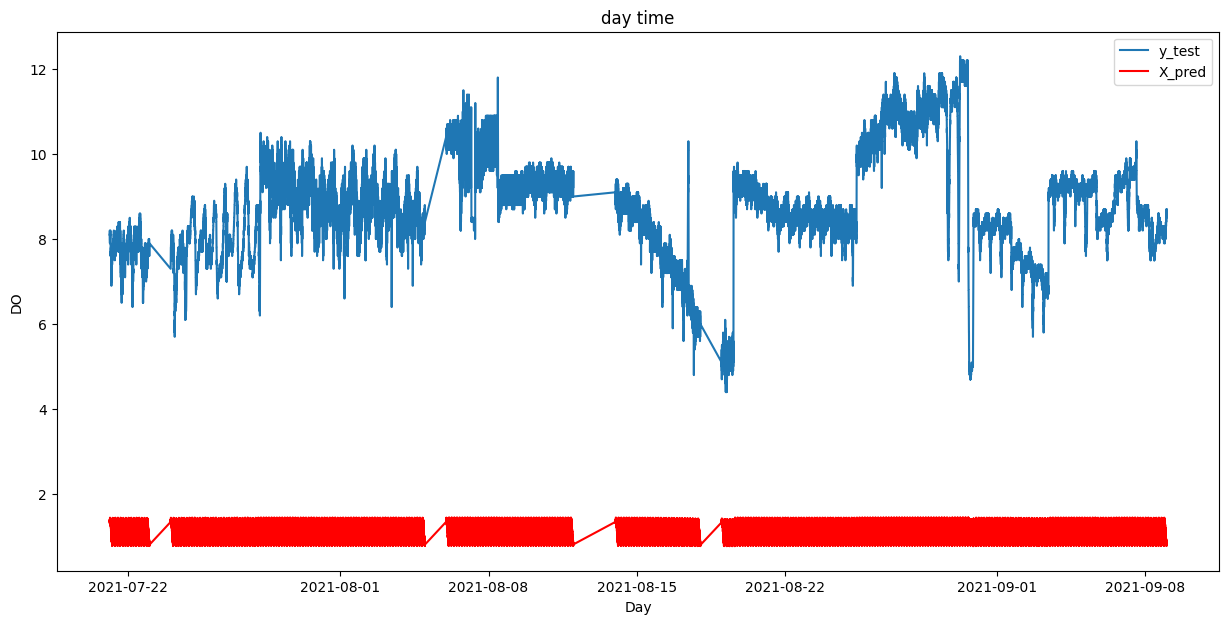

12/12 [==============================] - 2s 69ms/step - loss: 59.7156 - mae: 7.6301 - r_squared: -172.6753
MSE // MAE // R-squared  [59.71559524536133, 7.630124092102051, -172.67529296875]


In [220]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test, oneday_y_test_reshape)

12/12 [==============================] - 1s 67ms/step
64620


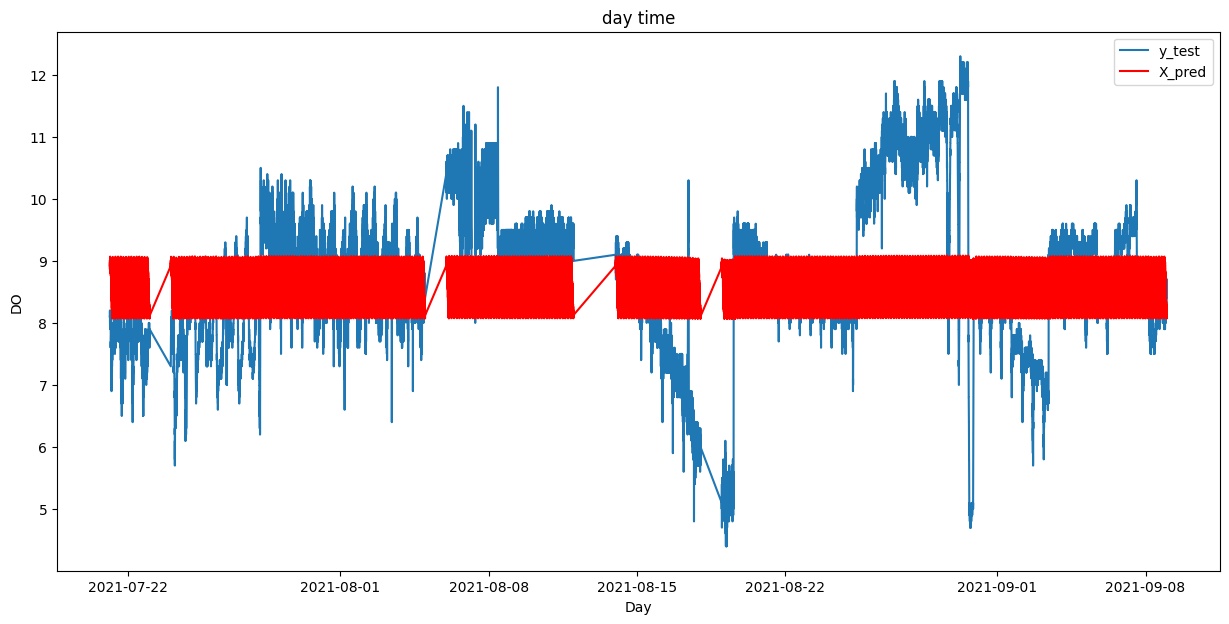

12/12 [==============================] - 1s 71ms/step - loss: 59.7156 - mae: 7.6301 - r_squared: -172.6753
MSE // MAE // R-squared  [59.71559524536133, 7.630124092102051, -172.67529296875]


In [221]:
grapeNEva2(model, oneday_X_test_reshape, oneday_y_test, oneday_y_test_reshape, min_value, max_value)

In [222]:
one_day_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-08 20:59']
oneday_X_test = one_day_data[['do_mg', 'feed_quantity']]

In [223]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max 스케일러 객체를 생성합니다.
scaler = MinMaxScaler()

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(oneday_X_test)
one_day_data = pd.DataFrame(normalized_data, columns=oneday_X_test.columns)




oneday_X_test = one_day_data

In [224]:
one_day_data = japonica_validation_data.loc['2021-07-21 03:00':'2021-09-08 23:59']
oneday_y_test = one_day_data[['do_mg', 'feed_quantity']]

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(oneday_y_test)
one_day_data = pd.DataFrame(normalized_data, columns=oneday_y_test.columns)

In [225]:
# 한주 동안의 데이터 추출
oneday_y_test = oneday_y_test[['do_mg']]
oneday_y_test1 = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 2))

oneday_y_test_reshape = np.asarray(oneday_y_test1, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 359 nVar: 2
nCar: 64620 nVar: 1
nCar: 359 nVar: 180


12/12 [==============================] - 1s 65ms/step
64620


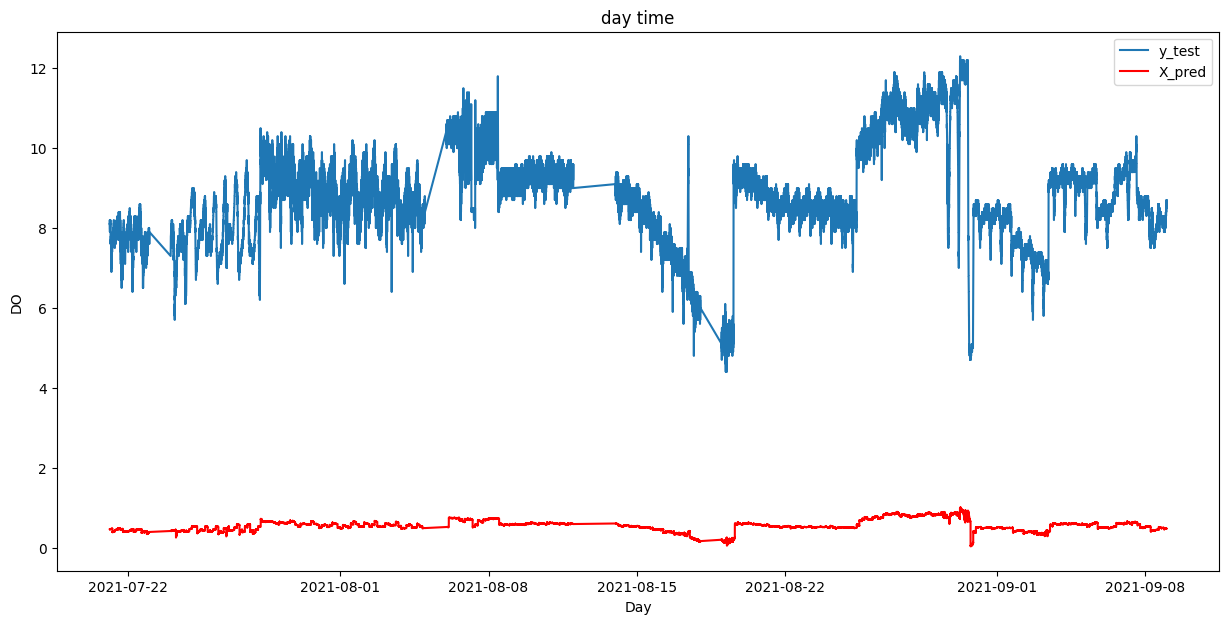

12/12 [==============================] - 1s 67ms/step - loss: 0.0051 - mae: 0.0449 - r_squared: 0.4158
MSE // MAE // R-squared  [0.005065924488008022, 0.04494301974773407, 0.4158284664154053]


In [226]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test, oneday_y_test_reshape)

12/12 [==============================] - 1s 65ms/step
64620


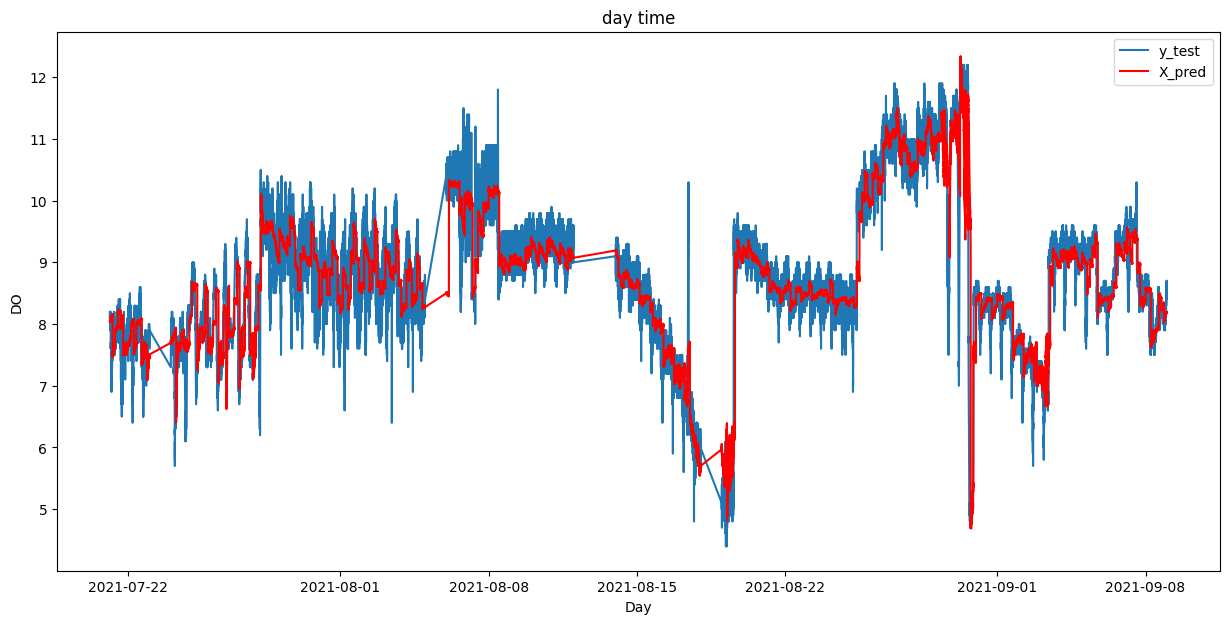

12/12 [==============================] - 1s 66ms/step - loss: 0.0051 - mae: 0.0449 - r_squared: 0.4158
MSE // MAE // R-squared  [0.005065924488008022, 0.04494301974773407, 0.4158284664154053]


In [227]:
min_value = scaler.data_min_[0]
max_value = scaler.data_max_[0]
grapeNEva2(model, oneday_X_test_reshape, oneday_y_test, oneday_y_test_reshape, min_value, max_value)

In [228]:
one_day_data = japonica_validation_data.loc['2021-07-29 00:00':'2021-07-29 20:59']
oneday_X_test = one_day_data[['do_mg', 'feed_quantity']]

In [229]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max 스케일러 객체를 생성합니다.
scaler = MinMaxScaler()

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(oneday_X_test)
one_day_data = pd.DataFrame(normalized_data, columns=oneday_X_test.columns)




oneday_X_test = one_day_data

In [230]:
one_day_data = japonica_validation_data.loc['2021-07-29 03:00':'2021-07-29 23:59']
oneday_y_test = one_day_data[['do_mg', 'feed_quantity']]

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(oneday_y_test)
one_day_data = pd.DataFrame(normalized_data, columns=oneday_y_test.columns)

In [231]:
# 한주 동안의 데이터 추출
oneday_y_test = oneday_y_test[['do_mg']]
oneday_y_test1 = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 2))

oneday_y_test_reshape = np.asarray(oneday_y_test1, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 7 nVar: 2
nCar: 1260 nVar: 1
nCar: 7 nVar: 180


1/1 [==============================] - 0s 67ms/step
1260


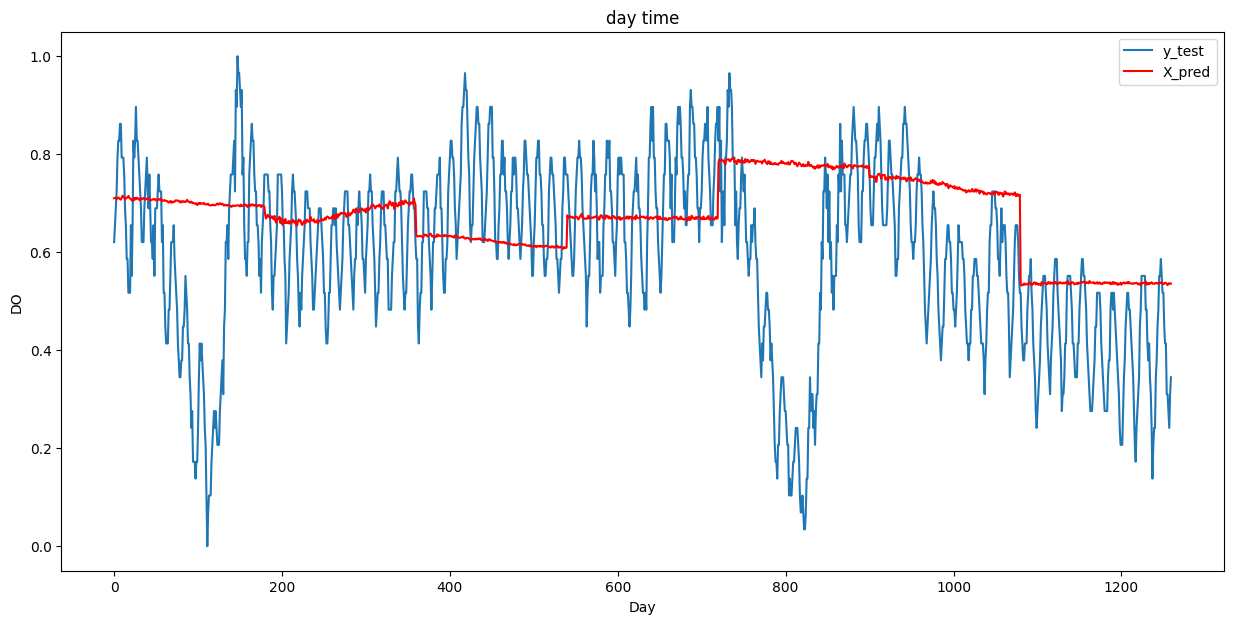

1/1 [==============================] - 0s 69ms/step - loss: 0.0418 - mae: 0.1490 - r_squared: -0.2370
MSE // MAE // R-squared  [0.04175347089767456, 0.14901116490364075, -0.23699820041656494]


In [232]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test1, oneday_y_test_reshape)

1/1 [==============================] - 0s 106ms/step
1260


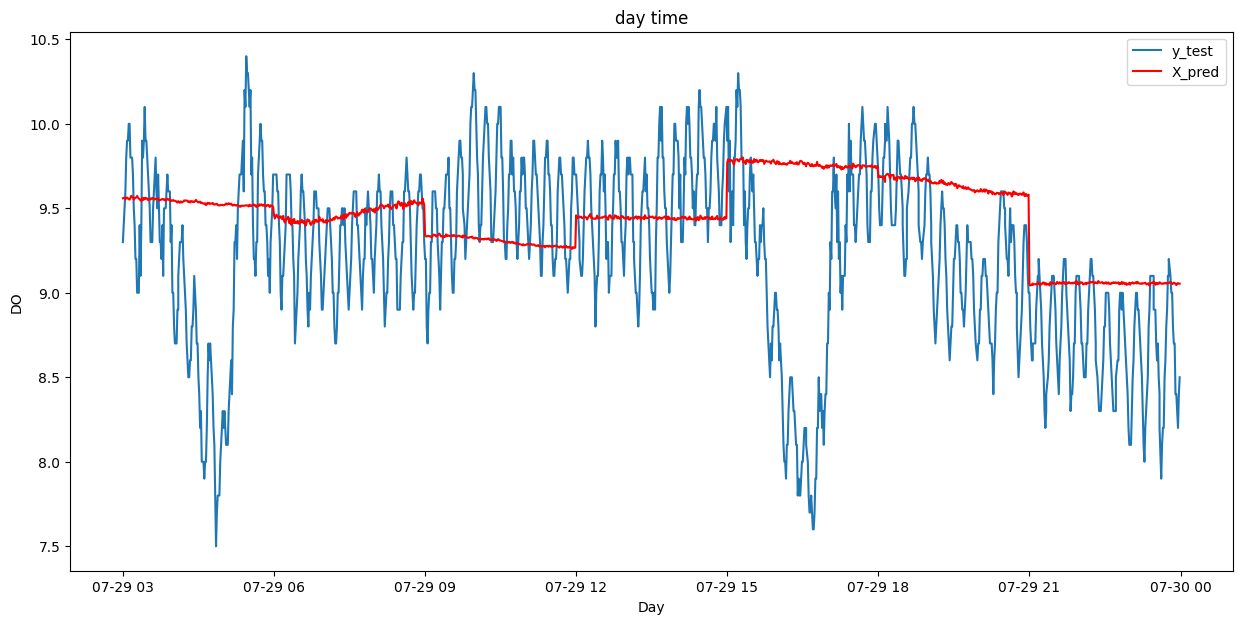

1/1 [==============================] - 0s 72ms/step - loss: 0.0418 - mae: 0.1490 - r_squared: -0.2370
MSE // MAE // R-squared  [0.04175347089767456, 0.14901116490364075, -0.23699820041656494]


In [233]:
min_value = scaler.data_min_[0]
max_value = scaler.data_max_[0]
grapeNEva2(model, oneday_X_test_reshape, oneday_y_test, oneday_y_test_reshape, min_value, max_value)

In [234]:
one_day_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-07-21 11:59']
oneday_X_test = one_day_data[['do_mg', 'feed_quantity']]

In [235]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max 스케일러 객체를 생성합니다.
scaler = MinMaxScaler()

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(oneday_X_test)
one_day_data = pd.DataFrame(normalized_data, columns=oneday_X_test.columns)




oneday_X_test = one_day_data

In [236]:
one_day_data = japonica_validation_data.loc['2021-07-21 03:00':'2021-07-21 14:59']
oneday_y_test = one_day_data[['do_mg', 'feed_quantity']]

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(oneday_y_test)
one_day_data = pd.DataFrame(normalized_data, columns=oneday_y_test.columns)

In [237]:
# 한주 동안의 데이터 추출
oneday_y_test = oneday_y_test[['do_mg']]
oneday_y_test1 = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 2))

oneday_y_test_reshape = np.asarray(oneday_y_test1, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 2
nCar: 720 nVar: 1
nCar: 4 nVar: 180


1/1 [==============================] - 0s 52ms/step


720


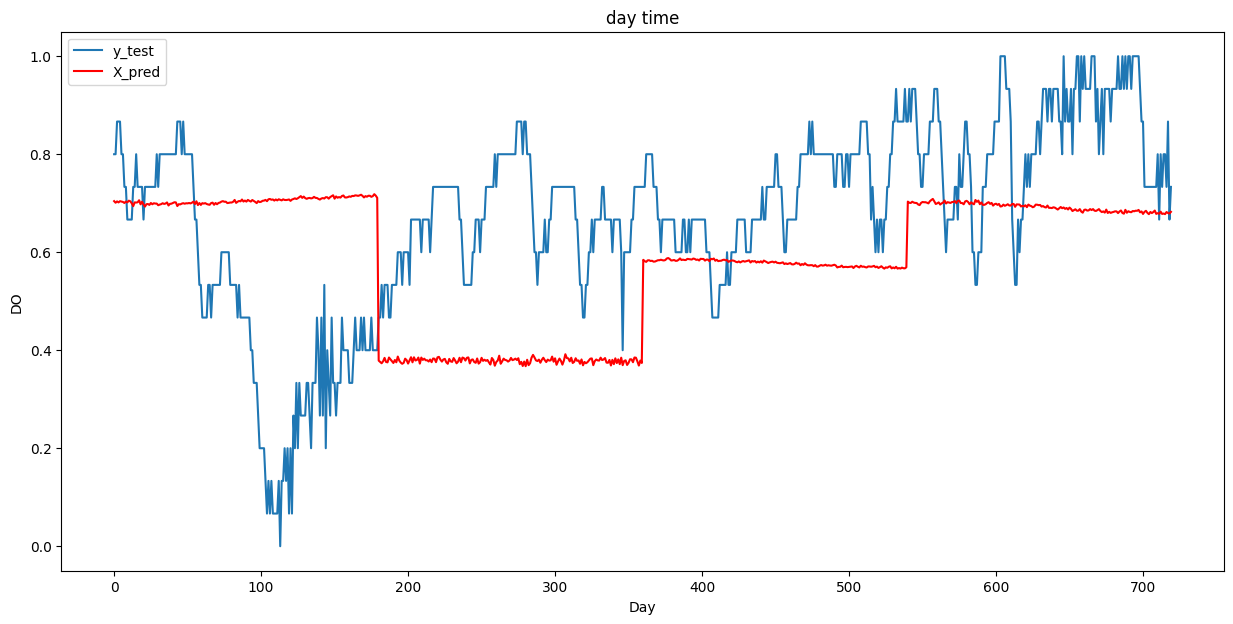

1/1 [==============================] - 0s 62ms/step - loss: 0.0642 - mae: 0.2141 - r_squared: -0.7509
MSE // MAE // R-squared  [0.06416216492652893, 0.2140883505344391, -0.7509193420410156]


In [238]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test1, oneday_y_test_reshape)

1/1 [==============================] - 0s 52ms/step
720


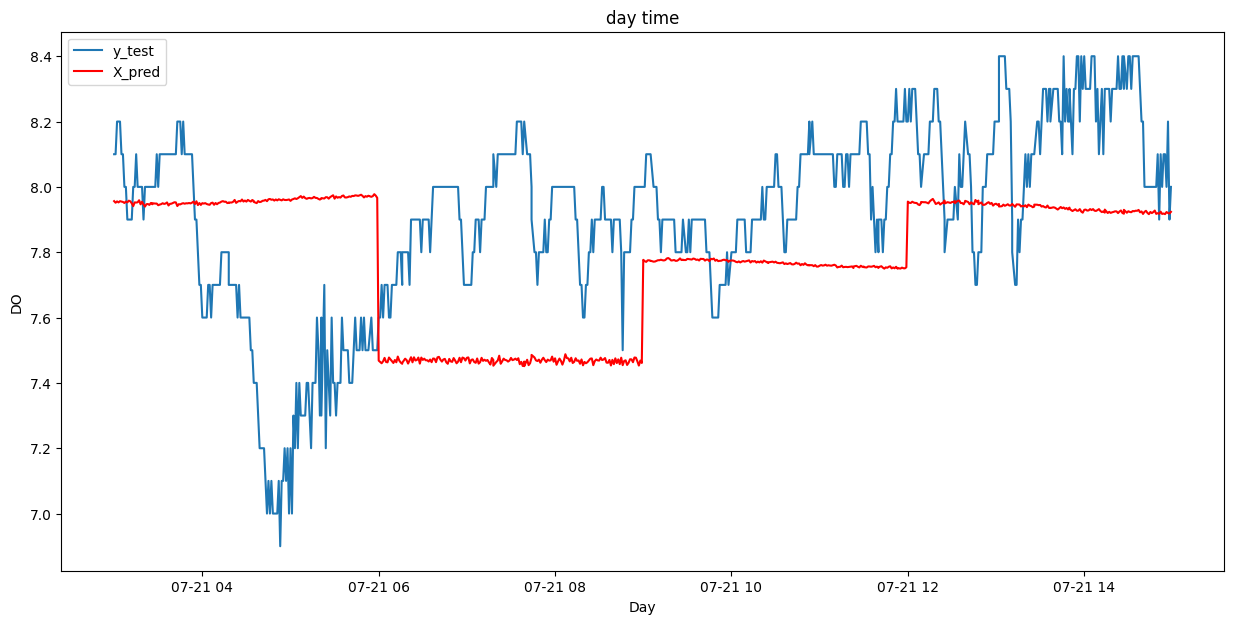

1/1 [==============================] - 0s 58ms/step - loss: 0.0642 - mae: 0.2141 - r_squared: -0.7509
MSE // MAE // R-squared  [0.06416216492652893, 0.2140883505344391, -0.7509193420410156]


In [239]:
min_value = scaler.data_min_[0]
max_value = scaler.data_max_[0]
grapeNEva2(model, oneday_X_test_reshape, oneday_y_test, oneday_y_test_reshape, min_value, max_value)

nCar: 4 nVar: 2
nCar: 720 nVar: 1
nCar: 4 nVar: 180
1/1 [==============================] - 0s 56ms/step
720


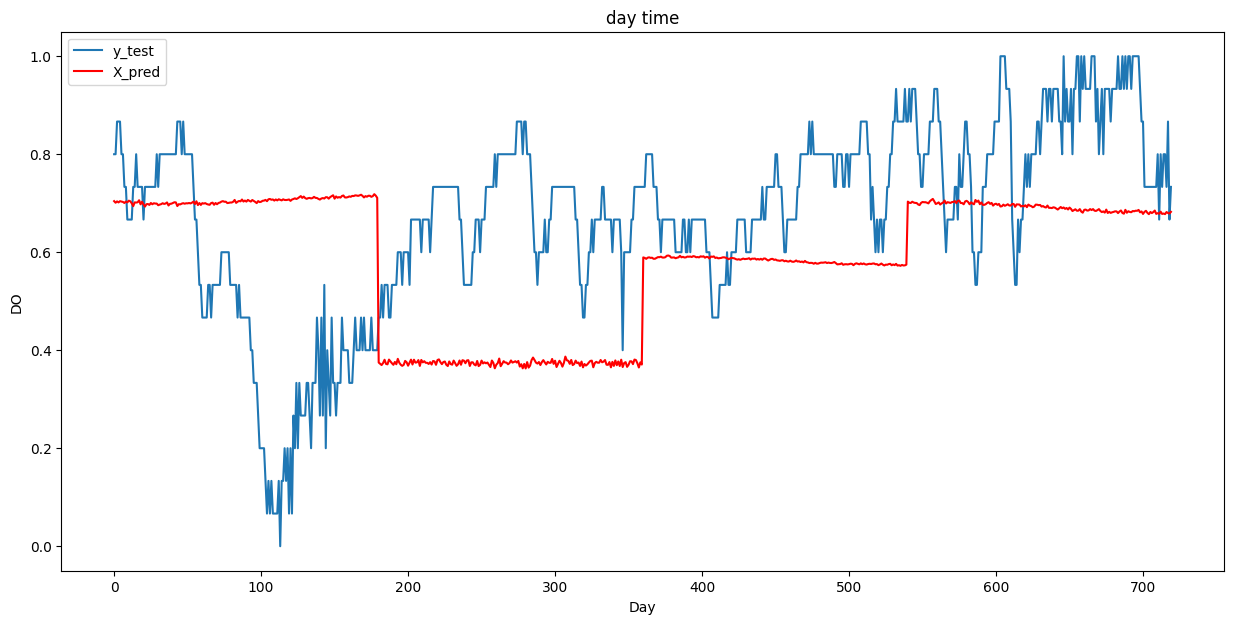

1/1 [==============================] - 0s 64ms/step - loss: 0.0645 - mae: 0.2141 - r_squared: -0.7604
MSE // MAE // R-squared  [0.06451044976711273, 0.2141040712594986, -0.760424017906189]
1/1 [==============================] - 0s 61ms/step
720


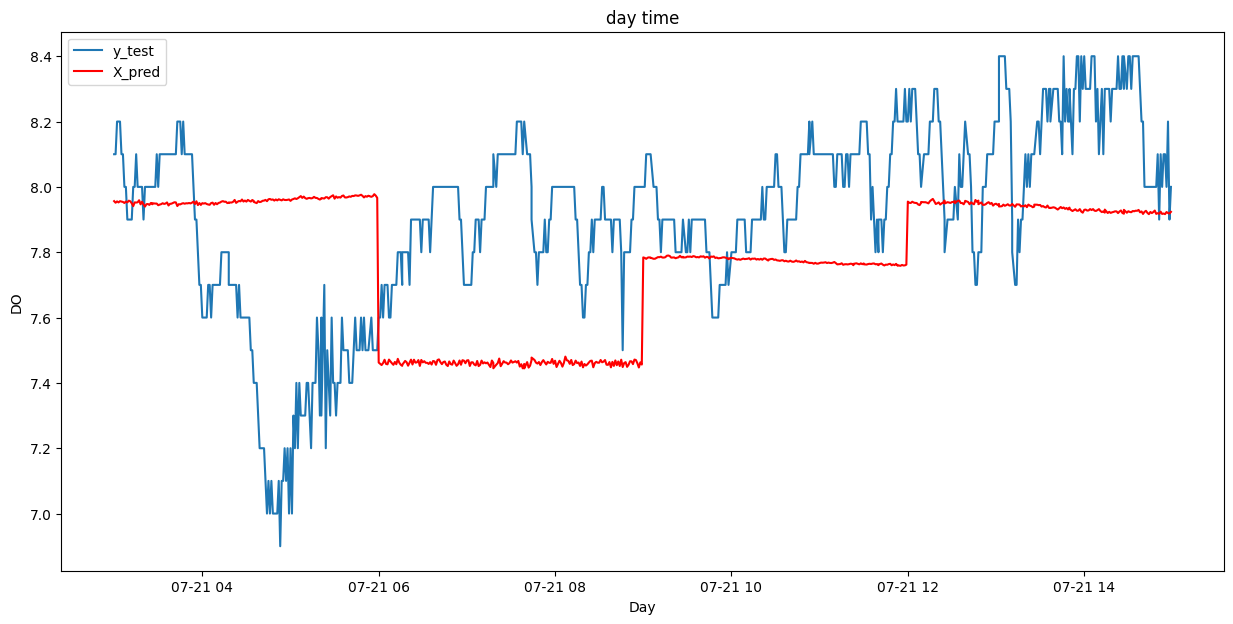

1/1 [==============================] - 0s 51ms/step - loss: 0.0645 - mae: 0.2141 - r_squared: -0.7604
MSE // MAE // R-squared  [0.06451044976711273, 0.2141040712594986, -0.760424017906189]


In [240]:
japonica_validation_data_change1 = japonica_validation_data
japonica_validation_data_change1.at['2021-07-21 08:00', 'feed_quantity'] = 16

one_day_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-07-21 11:59']
oneday_X_test = one_day_data[['do_mg', 'feed_quantity']]
from sklearn.preprocessing import MinMaxScaler

# Min-Max 스케일러 객체를 생성합니다.
scaler = MinMaxScaler()

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(oneday_X_test)
one_day_data = pd.DataFrame(normalized_data, columns=oneday_X_test.columns)




oneday_X_test = one_day_data
one_day_data = japonica_validation_data.loc['2021-07-21 03:00':'2021-07-21 14:59']
oneday_y_test = one_day_data[['do_mg', 'feed_quantity']]

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(oneday_y_test)
one_day_data = pd.DataFrame(normalized_data, columns=oneday_y_test.columns)
# 한주 동안의 데이터 추출
oneday_y_test = oneday_y_test[['do_mg']]
oneday_y_test1 = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 2))

oneday_y_test_reshape = np.asarray(oneday_y_test1, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )
grapeNEva(model, oneday_X_test_reshape, oneday_y_test1, oneday_y_test_reshape)
min_value = scaler.data_min_[0]
max_value = scaler.data_max_[0]
grapeNEva2(model, oneday_X_test_reshape, oneday_y_test, oneday_y_test_reshape, min_value, max_value)